# Ghost Demand Detection using Isolation Forest

## 1. Data Loading & Cleaning

In [3]:
import pandas as pd
df = pd.read_csv("../Data/Amazon Sale Report.csv")

/tmp/ipykernel_18399/2901936861.py:2: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/Amazon Sale Report.csv")


In [4]:
df.last_valid_index()

128974

In [5]:
#Checking the data
df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,IN Core Free Shipping 2015/04/08 23-48-5-108,True,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,NaN,False,Easy Ship,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,NaN,False,NaN,NaN


### Dropping the columns that are not required

In [6]:
# Keep only required columns
df = df[['Date', 'SKU', 'Qty', 'Status']]

In [7]:
df

,Date,SKU,Qty,Status
0,04-30-22,SET389-KR-NP-S,0,Cancelled
1,04-30-22,JNE3781-KR-XXXL,1,Shipped - Delivered to Buyer
2,04-30-22,JNE3371-KR-XL,1,Shipped
3,04-30-22,J0341-DR-L,0,Cancelled
4,04-30-22,JNE3671-TU-XXXL,1,Shipped
...,...,...,...,...
128970,05-31-22,JNE3697-KR-XL,1,Shipped
128971,05-31-22,SET401-KR-NP-M,1,Shipped
128972,05-31-22,J0157-DR-XXL,1,Shipped
128973,05-31-22,J0012-SKD-XS,1,Shipped


In [8]:
valid_status = ['Shipped', 'Delivered']

df = df[df['Status'].isin(valid_status)]

In [9]:
df

,Date,SKU,Qty,Status
2,04-30-22,JNE3371-KR-XL,1,Shipped
4,04-30-22,JNE3671-TU-XXXL,1,Shipped
5,04-30-22,SET264-KR-NP-XL,1,Shipped
6,04-30-22,J0095-SET-L,1,Shipped
9,04-30-22,JNE3461-KR-XXL,1,Shipped
...,...,...,...,...
128970,05-31-22,JNE3697-KR-XL,1,Shipped
128971,05-31-22,SET401-KR-NP-M,1,Shipped
128972,05-31-22,J0157-DR-XXL,1,Shipped
128973,05-31-22,J0012-SKD-XS,1,Shipped


### Convert order-level data to time-series demand

In [10]:
df['Date'].head(10)

2     04-30-22
4     04-30-22
5     04-30-22
6     04-30-22
9     04-30-22
10    04-30-22
11    04-30-22
13    04-30-22
16    04-30-22
17    04-30-22
Name: Date, dtype: object

In [11]:
df = df.copy()

# Parse Date ONCE, fail fast if anything is wrong
df['Date'] = pd.to_datetime(
    df['Date'].astype(str).str.strip(),
    format='%m-%d-%y',
    errors='raise'
)

In [12]:
df['Date'].isna().sum()

np.int64(0)

In [13]:
df['Date'].dtype

dtype('<M8[ns]')

In [14]:
df['Date'].isna().sum()

np.int64(0)

In [15]:
# Status filter first
valid_status = ['Shipped', 'Delivered']
df = df[df['Status'].isin(valid_status)].copy()

In [16]:
print(df['Date'].dtype)
print(df['Date'].isna().sum())

datetime64[ns]
0


## 2. Aggregation to Daily SKU-Level Demand


In [17]:
# Sort for time-series correctness
df = df.sort_values(['SKU', 'Date'])

# Aggregate to daily SKU-level demand
daily_df = (
    df.groupby(['Date', 'SKU'], as_index=False)
      .agg(daily_sales=('Qty', 'sum'))
)

In [18]:
print("Rows after aggregation:", len(daily_df))
daily_df.head()

Rows after aggregation: 53542


,Date,SKU,daily_sales
0,2022-03-31,J0003-SET-M,2
1,2022-03-31,J0003-SET-XL,1
2,2022-03-31,J0003-SET-XS,1
3,2022-03-31,J0008-SKD-S,1
4,2022-03-31,J0009-SKD-L,1


In [19]:
print("Rows before aggregation:", len(df))
print("Rows after aggregation:", len(daily_df))

Rows before aggregation: 77804
Rows after aggregation: 53542


In [20]:
df.groupby(['Date', 'SKU']).size().sort_values(ascending=False).head()

Date        SKU          
2022-05-27  JNE3797-KR-XL    33
2022-04-07  JNE3405-KR-L     28
2022-06-26  JNE3797-KR-L     27
2022-05-26  JNE3797-KR-M     25
2022-04-09  JNE3405-KR-L     24
dtype: int64

## 3. Feature Engineering (Expected Demand)

In [21]:
#Sorting the data
daily_df = daily_df.sort_values(['SKU', 'Date'])

In [22]:
daily_df['rolling_mean_7'] = (
    daily_df
    .groupby('SKU')['daily_sales']
    .transform(lambda x: x.rolling(7, min_periods=1).mean())
)

In [23]:
daily_df['rolling_std_7'] = (
    daily_df
    .groupby('SKU')['daily_sales']
    .transform(lambda x: x.rolling(7, min_periods=1).std())
    .fillna(0)
)

In [24]:
daily_df['forecast_error'] = (
    daily_df['rolling_mean_7'] - daily_df['daily_sales']
)

In [25]:
daily_df['demand_change'] = (
    daily_df
    .groupby('SKU')['daily_sales']
    .pct_change()
    .fillna(0)
)

daily_df['volatility_ratio'] = (
    daily_df['rolling_std_7'] / (daily_df['rolling_mean_7'] + 1e-6)
)

In [26]:
daily_df[['daily_sales', 'rolling_mean_7', 'forecast_error']].describe()

,daily_sales,rolling_mean_7,forecast_error
count,53542.000000,53542.000000,53542.000000
mean,1.456968,1.461550,0.004582
std,1.268882,0.960370,0.875448
min,0.000000,0.000000,-22.571429
25%,1.000000,1.000000,0.000000
50%,1.000000,1.142857,0.000000
75%,1.000000,1.571429,0.250000
max,33.000000,21.428571,12.142857


## 4. ML – Isolation Forest Training

In [27]:
from sklearn.ensemble import IsolationForest

features = [
    'daily_sales',
    'rolling_mean_7',
    'rolling_std_7',
    'forecast_error',
    'demand_change',
    'volatility_ratio'
]

X = daily_df[features]

iso_model = IsolationForest(
    n_estimators=300,
    max_samples=256,
    max_features=0.8,
    contamination=0.02,
    random_state=42
)

iso_model.fit(X)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",300
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",256
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.02
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",0.8
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


## 5. Ghost Demand Detection

In [28]:
daily_df['anomaly_score'] = iso_model.decision_function(X)
daily_df['anomaly_flag'] = iso_model.predict(X)

daily_df['ghost_demand'] = (
    (daily_df['anomaly_flag'] == -1) &
    (daily_df['forecast_error'] > 0)
).astype(int)

## 6. Optimization (OR-Tools)

In [29]:
from ortools.linear_solver import pywraplp

In [30]:
ghost_df = daily_df[daily_df['ghost_demand'] == 1].copy()

print(f"Ghost-demand cases to optimize: {len(ghost_df)}")

Ghost-demand cases to optimize: 467


In [31]:
# Business assumptions (mock but realistic)
UNIT_PRODUCTION_COST = 50      # cost per unit produced
UNIT_WASTE_PENALTY = 20        # waste / sustainability penalty per unit
MAX_REDUCTION_RATIO = 0.8      # do not cut more than 80% of excess demand


In [32]:
solver = pywraplp.Solver.CreateSolver('SCIP')

if solver is None:
    raise RuntimeError("Solver not available")

In [33]:
reduction_vars = {}

for idx, row in ghost_df.iterrows():
    max_cut = max(row['forecast_error'], 0) * MAX_REDUCTION_RATIO
    
    reduction_vars[idx] = solver.NumVar(
        0,
        max_cut,
        f"cut_{idx}"
    )

In [34]:
# (cost + waste) * production_cut

UNIT_PRODUCTION_COST = 50
UNIT_WASTE_PENALTY = 20
unit_penalty = UNIT_PRODUCTION_COST + UNIT_WASTE_PENALTY


In [35]:
objective = solver.Objective()

unit_penalty = UNIT_PRODUCTION_COST + UNIT_WASTE_PENALTY

for var in reduction_vars.values():
    objective.SetCoefficient(var, unit_penalty)

objective.SetMaximization()

In [36]:
status = solver.Solve()

if status != pywraplp.Solver.OPTIMAL:
    raise RuntimeError("Optimization did not find an optimal solution")

print("Optimization solved successfully.")

Optimization solved successfully.


In [37]:
status = solver.Solve()

if status != pywraplp.Solver.OPTIMAL:
    raise RuntimeError("Optimization did not find an optimal solution")

print("Optimization solved successfully.")


Optimization solved successfully.


In [38]:
ghost_df['recommended_cut'] = 0.0

for idx, var in reduction_vars.items():
    ghost_df.loc[idx, 'recommended_cut'] = var.solution_value()

In [39]:
ghost_df['cost_saving'] = ghost_df['recommended_cut'] * UNIT_PRODUCTION_COST
ghost_df['waste_reduction_value'] = ghost_df['recommended_cut'] * UNIT_WASTE_PENALTY

In [40]:
print("Total units reduced:", ghost_df['recommended_cut'].sum())
print("Total production cost saved:", ghost_df['cost_saving'].sum())
print("Total waste reduction value:", ghost_df['waste_reduction_value'].sum())

Total units reduced: 1264.0190476190478
Total production cost saved: 63200.95238095239
Total waste reduction value: 25280.380952380954


In [41]:
ghost_df[[
    'Date',
    'SKU',
    'daily_sales',
    'rolling_mean_7',
    'forecast_error',
    'recommended_cut',
    'cost_saving',
    'waste_reduction_value'
]].sort_values('recommended_cut', ascending=False).head(10)

,Date,SKU,daily_sales,rolling_mean_7,forecast_error,recommended_cut,cost_saving,waste_reduction_value
11008,2022-04-17,JNE3405-KR-L,4,16.142857,12.142857,9.714286,485.714286,194.285714
23309,2022-05-07,JNE3405-KR-L,1,12.571429,11.571429,9.257143,462.857143,185.142857
52647,2022-06-27,JNE3797-KR-L,3,13.857143,10.857143,8.685714,434.285714,173.714286
28221,2022-05-17,JNE3405-KR-S,1,11.285714,10.285714,8.228571,411.428571,164.571429
11583,2022-04-18,JNE3405-KR-L,4,14.285714,10.285714,8.228571,411.428571,164.571429
8488,2022-04-13,JNE3405-KR-S,3,13.142857,10.142857,8.114286,405.714286,162.285714
9151,2022-04-14,JNE3405-KR-S,2,11.857143,9.857143,7.885714,394.285714,157.714286
4258,2022-04-06,SET268-KR-NP-L,3,12.833333,9.833333,7.866667,393.333333,157.333333
12147,2022-04-19,JNE3405-KR-L,3,12.428571,9.428571,7.542857,377.142857,150.857143
9816,2022-04-15,JNE3405-KR-S,1,10.142857,9.142857,7.314286,365.714286,146.285714


### Once ghost demand is detected, we use mathematical optimization to compute the optimal production cut for each product-day, constrained by business limits. This allows us to directly quantify cost savings and waste reduction.

In [42]:
ghost_df['recommended_cut'].describe()

count    467.000000
mean       2.706679
std        1.632271
min        0.114286
25%        1.600000
50%        2.560000
75%        3.485714
max        9.714286
Name: recommended_cut, dtype: float64

In [43]:
ghost_df['cost_saving'].sum(), ghost_df['waste_reduction_value'].sum()

(np.float64(63200.95238095239), np.float64(25280.380952380954))

### Across ~53,000 daily product observations, our system identified ~467 ghost-demand cases. For these, the optimizer recommends an average production cut of ~2.7 units per case, resulting in approximately ₹63K in cost savings and ₹25K in waste reduction—without impacting normal demand

## 7. Results & Insights

In [44]:
daily_df['ghost_demand'].value_counts()

ghost_demand
0    53075
1      467
Name: count, dtype: int64

In [45]:
total_rows = len(daily_df)
ghost_rows = daily_df['ghost_demand'].sum()

ghost_pct = (ghost_rows / total_rows) * 100

print(f"Total SKU-days analysed: {total_rows}")
print(f"Ghost demand cases detected: {ghost_rows}")
print(f"Ghost demand rate: {ghost_pct:.2f}%")

Total SKU-days analysed: 53542
Ghost demand cases detected: 467
Ghost demand rate: 0.87%


In [46]:
daily_df[daily_df['ghost_demand'] == 1] \
    .sort_values('forecast_error', ascending=False) \
    .head(10)[[
        'Date',
        'SKU',
        'daily_sales',
        'rolling_mean_7',
        'forecast_error'
    ]]

,Date,SKU,daily_sales,rolling_mean_7,forecast_error
11008,2022-04-17,JNE3405-KR-L,4,16.142857,12.142857
23309,2022-05-07,JNE3405-KR-L,1,12.571429,11.571429
52647,2022-06-27,JNE3797-KR-L,3,13.857143,10.857143
28221,2022-05-17,JNE3405-KR-S,1,11.285714,10.285714
11583,2022-04-18,JNE3405-KR-L,4,14.285714,10.285714
8488,2022-04-13,JNE3405-KR-S,3,13.142857,10.142857
9151,2022-04-14,JNE3405-KR-S,2,11.857143,9.857143
4258,2022-04-06,SET268-KR-NP-L,3,12.833333,9.833333
12147,2022-04-19,JNE3405-KR-L,3,12.428571,9.428571
9816,2022-04-15,JNE3405-KR-S,1,10.142857,9.142857


In [47]:
sku_impact = (
    daily_df[daily_df['ghost_demand'] == 1]
    .groupby('SKU')
    .agg(
        ghost_days=('ghost_demand', 'count'),
        avg_forecast_gap=('forecast_error', 'mean'),
        max_forecast_gap=('forecast_error', 'max')
    )
    .sort_values('ghost_days', ascending=False)
)

sku_impact.head(10)

,ghost_days,avg_forecast_gap,max_forecast_gap
SKU,,,
SET268-KR-NP-XL,22,2.787662,5.142857
SET268-KR-NP-L,19,2.802130,9.833333
SET268-KR-NP-S,19,2.495739,5.142857
JNE3405-KR-L,17,6.050420,12.142857
J0230-SKD-S,17,2.616807,5.285714
J0230-SKD-M,16,2.997024,6.714286
JNE3405-KR-S,16,5.084821,10.285714
JNE3405-KR-XS,14,3.091837,5.428571
J0341-DR-M,14,2.612245,6.000000


### What does ghost demand mean in our system?

Ghost demand is detected when:
- Historical data suggests a product should sell well (high rolling average)
- Actual sales fall significantly below expectation
- The pattern is statistically rare compared to normal behavior

These cases indicate inflated demand signals that could lead to overproduction.


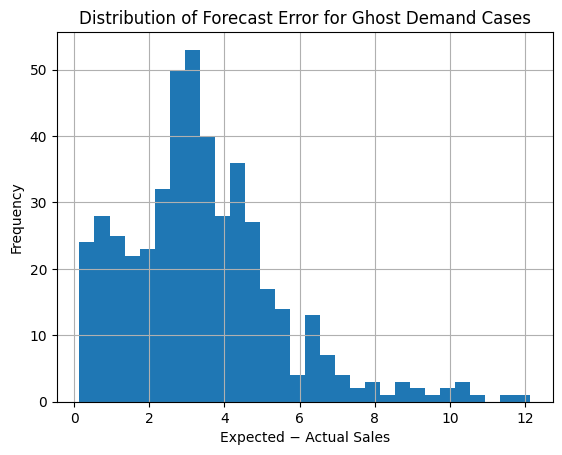

In [48]:
import matplotlib.pyplot as plt

daily_df[daily_df['ghost_demand'] == 1]['forecast_error'].hist(bins=30)
plt.title("Distribution of Forecast Error for Ghost Demand Cases")
plt.xlabel("Expected − Actual Sales")
plt.ylabel("Frequency")
plt.show()

### Out of ~53,000 daily product observations, our system identified ~470 cases of ghost demand less than 1%. These cases are concentrated in a small set of products where expected demand remained high but actual sales dropped, indicating risk of overproduction. We then use optimization to recommend corrective production actions

In [49]:
# Data for streamlit dashboard
import os

os.makedirs("outputs", exist_ok=True)

final_df = ghost_df[[
    "Date",
    "SKU",
    "daily_sales",
    "rolling_mean_7",
    "forecast_error",
    "ghost_demand",
    "recommended_cut",
    "cost_saving",
    "waste_reduction_value"
]].copy()

final_df.to_csv("outputs/final_results.csv", index=False)


## 8. AI Explainability Using Gemini 

In [50]:
from google import genai
import os